## Methane 1


Methane 1のgroファイルを作ってみよう。

In [3]:
import gromacs
import numpy as np


CH = 0.1087  # nm

# 六方最密充填構造
L = 3**0.5
H = (3 / 2) ** 0.5
hcp = np.array([[0, 0, 0], [0.5, L / 2, 0], [0, L * 2 / 3, H], [0.5, L / 6, H]])

CC = 0.4
carbons = hcp * CC
cell = np.diag([1, L, H * 2]) * CC
carbons = carbons @ np.linalg.inv(cell)

replicate = np.array([4, 4, 4])
rep_carbons = []
# 座標を3倍に増やす。もとがfractional座標なので、0〜3の範囲になる。
for x in range(replicate[0]):
    for y in range(replicate[0]):
        for z in range(replicate[0]):
            rep_carbons.append(carbons + np.array([x, y, z]))
# 座標を0〜1におさめる
rep_carbons = np.vstack(rep_carbons) / replicate
# セルを大きくする。
# 行ごとに係数をかけたい。
# 多少なりとも読みやすく
rep_cell = np.vstack(
    [cell[0, :] * replicate[0], cell[1, :] * replicate[1], cell[2, :] * replicate[2]]
)
print(rep_cell)

abs_carbons = rep_carbons @ rep_cell

hydrogens = (
    np.array([[-1, -1, -1], [-1, +1, +1], [+1, -1, +1], [+1, +1, -1]]) / 3**0.5 * CH
)


residues = dict()
residues["MET"] = [
    [
        ["C", pos],
        ["H", pos + hydrogens[0]],
        ["H", pos + hydrogens[1]],
        ["H", pos + hydrogens[2]],
        ["H", pos + hydrogens[3]],
    ]
    for pos in abs_carbons
]

frame = gromacs.compose(residues, rep_cell)
with open("MeV.gro", "w") as f:
    gromacs.write_gro(frame, f)

[[1.6        0.         0.        ]
 [0.         2.77128129 0.        ]
 [0.         0.         3.91918359]]


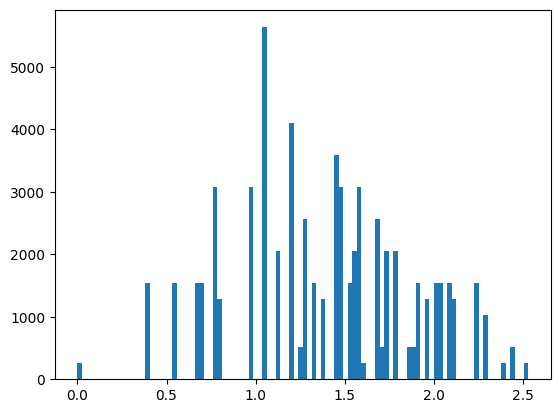

In [5]:
import matplotlib.pyplot as plt
distances = []
for i, ci in enumerate(rep_carbons):
    vectors = []
    for cj in rep_carbons:
        d = ci - cj
        # PBC
        d -= np.floor(d + 0.5)
        # fractional to absolute
        d = d @ rep_cell
        distances.append(np.linalg.norm(d))

H = plt.hist(distances, bins=100)